In [29]:
! pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
! pip install seaborn
import seaborn as sns
import networkx as nx


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


###  Uniformly Sampling DAGs
Talvitie and Koivisto 

Generates a random permutation of the nodes to establish an ordering.

This ordering ensures acyclicity since edges are only added from earlier nodes to later nodes.

For each node (except the first), we consider all previous nodes in the ordering as potential parents.

We randomly choose a number of parents for the current node, uniformly between 0 and max_parents (or the number of possible parents).

Parents are selected uniformly at random from the possible parents

By uniformly selecting the number of parents and the parents themselves, we ensure that each possible DAG has an equal probability of being sampled under the constraints.

In [30]:

def sample_uniform_dag(num_nodes, max_parents=None):
    nodes = list(range(num_nodes))
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    
   
    ordering = np.random.permutation(nodes)
    
    for i in range(1, num_nodes):
        current_node = ordering[i]
        possible_parents = ordering[:i]
        

        if max_parents is not None:
            max_p = min(len(possible_parents), max_parents)
        else:
            max_p = len(possible_parents)
        
        num_parents = np.random.randint(0, max_p + 1)
        
        parents = np.random.choice(possible_parents, size=num_parents, replace=False)

        for parent in parents:
            G.add_edge(parent, current_node)
    
    return G

In [31]:
num_nodes = 25  # Number of nodes in the DAG
max_parents = 4  # Maximum number of parents per node (optional)
N = 1000  # Number of data samples to generate
alpha = 1.0  # Dirichlet parameter (uniform prior)

In [32]:
node_states = {node: [0, 1] for node in range(num_nodes)}
    
# G is my model 
G = sample_uniform_dag(num_nodes, max_parents=max_parents)

In [38]:
import itertools
import pandas as pd
def sample_theta_given_g(G, node_states, alpha=1.0):
    theta = {}
    nodes = list(nx.topological_sort(G))
    for node in nodes:
        parents = list(G.predecessors(node))
        node_state_space = node_states[node]
        num_node_states = len(node_state_space)
        
        if len(parents) == 0:
           
            alpha_vector = np.full(num_node_states, alpha)
            probabilities = np.random.dirichlet(alpha_vector)
            theta[node] = {}
            theta[node][()] = probabilities  
        else:
            
            parent_states = [node_states[parent] for parent in parents]
            parent_configurations = list(itertools.product(*parent_states))
            theta[node] = {}
            for parent_config in parent_configurations:
                # Sample Dirichlet 
                alpha_vector = np.full(num_node_states, alpha)
                probabilities = np.random.dirichlet(alpha_vector)
                theta[node][parent_config] = probabilities
    return theta

In [39]:
theta = sample_theta_given_g(G, node_states, alpha=alpha )# p(theta|G)

In [40]:
def generate_data(G, theta, node_states, N):
    nodes = list(nx.topological_sort(G))
    data = []
    for _ in range(N):
        sample = {}
        for node in nodes:
            parents = list(G.predecessors(node))
            if len(parents) == 0:
                # Sample from the prior distribution 
                probabilities = theta[node][()]
                node_value = np.random.choice(node_states[node], p=probabilities)
                sample[node] = node_value
            else:
                # Sample from the conditional distribution
                parent_values = tuple(sample[parent] for parent in parents)
                probabilities = theta[node][parent_values]
                node_value = np.random.choice(node_states[node], p=probabilities)
                sample[node] = node_value
        data.append(sample)
    return pd.DataFrame(data)

In [41]:
df = generate_data(G, theta, node_states, N)

In [43]:
plt.figure(figsize=(32, 24))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, arrowstyle='->', arrowsize=20)
plt.title("Uniformly Sampled Bayesian Network Structure (DAG)")
#plt.show()
plt.savefig("Uniformly Sampled Bayesian Network Structure (DAG")
plt.close()    

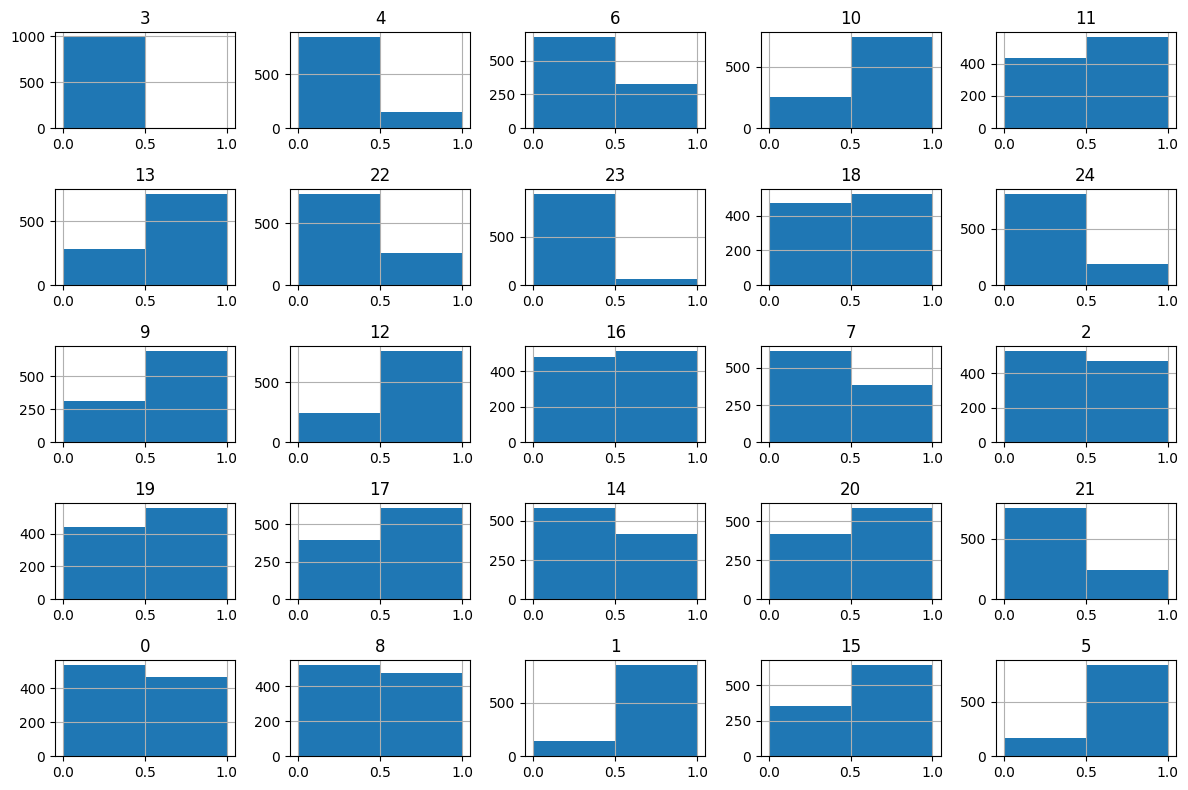

In [ ]:

df.hist(bins=2, figsize=(12, 8))
plt.tight_layout()
plt.show()

In [63]:
df.to_csv('data.data', sep=' ', index=False, header=False)
arities = [len(node_states[node]) for node in sorted(node_states.keys())]
with open('data.arities', 'w') as f:
    for arity in arities:
        f.write(f'{arity}\n')

In [45]:
with open('gobnilp.set', 'w') as f:
        f.write('gobnilp/scoring/family = "bdeu"\n')
        f.write('gobnilp/scoring/bdeuess = 1.0\n')
        f.write('gobnilp/localscoring = TRUE\n')
        f.write(f'gobnilp/maxparents = {max_parents}\n')

In [ ]:
command = [
        '../thesis/pygobnilp/pygobnilp',              
        '-g', 'data.data',
        '-a', 'data.arities',
        '-s', 'gobnilp.set',
        '-o', 'output.dag'
    ]

In [5]:
from pygobnilp.gobnilp import Gobnilp
from pygobnilp.scoring import BDeu

g = Gobnilp()

g.params.setParam('scoring/ess', 1.0)           
g.params.setParam('scoring/family', 'bdeu')   
g.params.setParam('maxparents', 4)             

number_of_variables = 25 

arities = [2] * number_of_variables


with open('/home/gulce/Downloads/thesis/data.data', 'r') as f:
    first_line = f.readline()
    num_variables_in_data = len(first_line.strip().split())
print("Number of variables in data:", num_variables_in_data)


if num_variables_in_data != number_of_variables:
    raise ValueError("Number of variables in data does not match number of arities.")


g.read_data('/home/gulce/Downloads/thesis/data.data', arities=arities)

g.learn()

learned_dag = g.learned_bn


print("Learned edges:", list(learned_dag.edges()))



Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0


AttributeError: No parameter named 'setParam'

Variable 1 unique values: [0 1]
Variable 2 unique values: [0 1]
Variable 3 unique values: [0 1]
Variable 4 unique values: [0 1]
Variable 5 unique values: [0 1]
Variable 6 unique values: [0 1]
Variable 7 unique values: [0 1]
Variable 8 unique values: [0 1]
Variable 9 unique values: [0 1]
Variable 10 unique values: [0 1]
Variable 11 unique values: [0 1]
Variable 12 unique values: [0 1]
Variable 13 unique values: [0 1]
Variable 14 unique values: [0 1]
Variable 15 unique values: [0 1]
Variable 16 unique values: [0 1]
Variable 17 unique values: [0 1]
Variable 18 unique values: [0 1]
Variable 19 unique values: [0 1]
Variable 20 unique values: [0 1]
Variable 21 unique values: [0 1]
Variable 22 unique values: [0 1]
Variable 23 unique values: [0 1]
Variable 24 unique values: [0 1]
Variable 25 unique values: [0 1]
